In [5]:
import pandas as pd
from pathlib import Path
import torch
import transformers
import random
import transformers
from nltk import pos_tag
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Antonio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
RESOURCES_DIR = Path("../resources")
DATASETS_PATH = RESOURCES_DIR / "datasets"
WORD_EMBEDDINGS_NAME = "glove.42B.300d"
DUMPS_DIR = RESOURCES_DIR / "DUMPS"

In [7]:
SIMPLETEXT_DATASET_PATH = DATASETS_PATH / "simpleText"

In [8]:
complex_text = pd.read_csv(SIMPLETEXT_DATASET_PATH / "simpleText.train.complex.txt", header=None, sep="\t", names=["original_text"])
simple_text = pd.read_csv(SIMPLETEXT_DATASET_PATH / "simpleText.train.simple.txt", header=None, sep="\t",names=["simple_text"])

In [9]:
sentences_pairs = pd.concat([complex_text, simple_text], axis=1)
sentences_pairs

,original_text,simple_text
0,"In the modern era of automation and robotics, ...",Current academic and industrial research is in...
1,With the ever increasing number of unmanned ae...,Drones are increasingly used in the civilian a...
2,Due to guidelines set by the governments regar...,Governments set guidelines on the operation ce...
3,In an attempt to achieve the above mentioned t...,Researchers propose data-driven solutions allo...
4,Derived from the classic image classification ...,"The algorithm, based on the Inception model, d..."
...,...,...
643,Bodybuilders generally train with moderate loa...,Bodybuilders train with moderate loads and sho...
644,"Powerlifters, on the other hand, routinely tra...","Powerlifters, on the other hand, train with hi..."
645,Although both groups are known to display impr...,Although both groups are known to display impr...
646,It has been shown that many factors mediate th...,It has been shown that many factors mediate th...


In [10]:
model = transformers.AutoModelWithLMHead.from_pretrained('lordtt13/COVID-SciBERT')
tokenizer = transformers.AutoTokenizer.from_pretrained('lordtt13/COVID-SciBERT')

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\transformers\models\auto\modeling_auto.py:742: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [11]:
def mask_sentence_prediction(text, topk=50):
    #print("----------------------")
    sentence_tokens = [token[0] for token in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]
    pos_tagging_sentence = pos_tag(sentence_tokens)
    #print(pos_tag(sentence_tokens))
    #print(len(pos_tagging_sentence))
    predictions = []
    for i, (word, pos) in enumerate(pos_tagging_sentence):

        #print(f"i:{i}, word:{word}, pos:{pos}")
        if pos in ['NNS', 'NN', 'VBP', 'RB', 'VBG','VBD','JJ','VBN','VB','VBZ','JJS','JJR']:
            sentence_masked = sentence_tokens.copy()
            sentence_masked[i] = "[MASK]"
            sentence_final = " ".join(sentence_masked)
            #print(sentence_final)
            inputs = tokenizer(sentence_final, return_tensors="pt")
            token_logits = model(**inputs).logits
            mask_token_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]
            mask_token_logits = token_logits[0,mask_token_index,:]
            top_n_tokens = torch.topk(mask_token_logits,topk,dim=1).indices[0].tolist()
            predicted_tokens = [tokenizer.decode([token]) for token in top_n_tokens]
            if word in predicted_tokens:
                predictions.append(predicted_tokens.index(word))


    predictions = [np.log(pred+1) for pred in predictions]
    #print(predictions)
    if len(predictions) == 0:
            return np.log(1 + topk*50)

    value = np.quantile(predictions, 0.75)
    return value

In [13]:
def check_pair_sentence(complex, simple):
    complex_feature = mask_sentence_prediction(complex)
    simple_feature = mask_sentence_prediction(simple)
    #print(f"Complex feature: {complex_feature}. Simple feature: {simple_feature}")
    if complex_feature !=0:
        value = simple_feature/complex_feature
    else:
        value = 1
    if value > 5:
        print(f"Complex feature: {complex_feature}. Simple feature: {simple_feature}")
    return min(value,2)

In [14]:
complex = "The computational efficiency of MAVNet enables the drone to fly at high speeds of up to 6m/sec."
simple = "MAVNet computational efficiency enables the drone to fly up to 6m/sec."

In [15]:
check_pair_sentence(complex, simple)

1.150763436666551

In [16]:
%time
results = []
for i,row in sentences_pairs.iterrows():
    value = check_pair_sentence(row['original_text'], row['simple_text'])
    results.append(value)
    if i == 100:
        break

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
len(results)

101

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


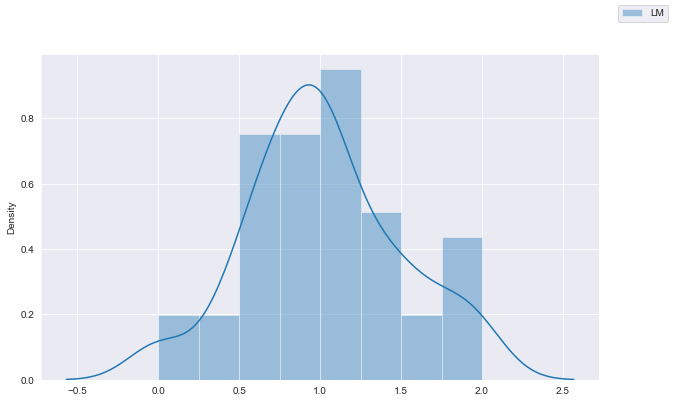

In [19]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results,label="LM")
fig.legend(labels=['LM'])
plt.show()

In [20]:
np.mean(results)

1.020897350040481

In [21]:
len(results)

101

c:\users\antonio\pycharmprojects\simpletextclef\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


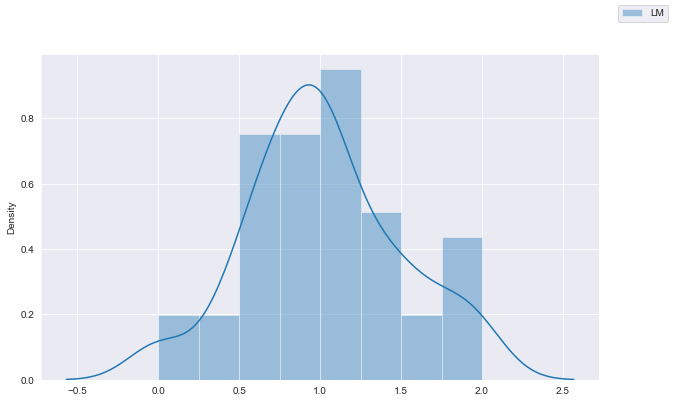

In [22]:
fig = plt.figure(figsize=(10,6))
sns.distplot(results,label="LM")
fig.legend(labels=['LM'])
plt.show()

In [23]:
np.mean(results)

1.020897350040481